# Objectives

## Context

We want to predict for the next 7 days the **flow of cars** and **occupancy rate** (two numerical targets) of the Champs-Elysées for a delivering company, OscarGoodFood Ltd.

The dataset comes from the official website of Paris ( https://opendata.paris.fr/pages/home/), and is available since 2014. Nonetheless, as there still were lockdowns in France in 2021, I only used 2022 + 2023 data. 

For the weather, the dataset comes from https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?sort=date. 

## General Pipeline

1. Some formatting before EDA, especially for dates and adding holidays and meteo data, 
2. Exploratory Data Analysis (Form Analysis, Content Analysis and Feature/Target analysis), 
3. Preprocessing
4. Machine Learning Benchmark, 
5. Tuning the most promising models, 
6. Forecast for the next 7 days, 
7. General Conclusion. 

# Libraries and data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None) # allows to see all columns 

In [ ]:
data = pd.read_csv('comptage-routier-permanents.csv', sep = ";")
data.head()

,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
0,4264,AV_Champs_Elysees,2022-12-07T00:00:00+01:00,528.0,68.14334,Bloqué,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605, 2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777..."
1,4264,AV_Champs_Elysees,2022-12-06T23:00:00+01:00,340.0,84.05333,Bloqué,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605, 2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777..."
2,4264,AV_Champs_Elysees,2022-12-06T21:00:00+01:00,712.0,61.27722,Bloqué,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605, 2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777..."
3,4264,AV_Champs_Elysees,2022-12-06T19:00:00+01:00,1121.0,53.63722,Bloqué,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605, 2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777..."
4,4264,AV_Champs_Elysees,2022-12-06T17:00:00+01:00,1126.0,30.92556,Saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605, 2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777..."


In [ ]:
data_meteo = pd.read_csv('donnees-synop-essentielles-omm.csv', sep = ";")
data_meteo.head()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,Visibilité horizontale,Temps présent,Temps passé 1,Temps passé 2,Nebulosité totale,Nébulosité des nuages de l' étage inférieur,Hauteur de la base des nuages de l'étage inférieur,Type des nuages de l'étage inférieur,Type des nuages de l'étage moyen,Type des nuages de l'étage supérieur,Pression station,Niveau barométrique,Géopotentiel,Variation de pression en 24 heures,Température minimale sur 12 heures,Température minimale sur 24 heures,Température maximale sur 12 heures,Température maximale sur 24 heures,Température minimale du sol sur 12 heures,Méthode de mesure Température du thermomètre mouillé,Température du thermomètre mouillé,Rafale sur les 10 dernières minutes,Rafales sur une période,Periode de mesure de la rafale,Etat du sol,"Hauteur totale de la couche de neige, glace, autre au sol",Hauteur de la neige fraîche,Periode de mesure de la neige fraiche,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Précipitations dans les 24 dernières heures,Phénomène spécial 1,Phénomène spécial 2,Phénomène spécial 3,Phénomène spécial 4,Nébulosité couche nuageuse 1,Type nuage 1,Hauteur de base 1,Nébulosité couche nuageuse 2,Type nuage 2,Hauteur de base 2,Nébulosité couche nuageuse 3,Type nuage 3,Hauteur de base 3,Nébulosité couche nuageuse 4,Type nuage 4,Hauteur de base 4,Coordonnees,Nom,Type de tendance barométrique.1,Temps passé 1.1,Temps présent.1,Température (°C),Température minimale sur 12 heures (°C),Température minimale sur 24 heures (°C),Température maximale sur 12 heures (°C),Température maximale sur 24 heures (°C),Température minimale du sol sur 12 heures (en °C),Latitude,Longitude,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,7149,2022-09-14T23:00:00+02:00,100680,140.0,En hausse,330,3.1,293.85,290.65,82,18270.0,On n’a pas observé d’évolution des nuages ou o...,NaN,NaN,NaN,1.0,1250.0,NaN,NaN,NaN,99640.0,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,9.5,-10.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.2,0.2,NaN,NaN,NaN,NaN,1.0,NaN,1380.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.716833, 2.384333",ORLY,En hausse,NaN,On n’a pas observé d’évolution des nuages ou o...,20.7,NaN,NaN,NaN,NaN,NaN,48.716833,2.384333,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,9
1,7149,2022-10-03T20:00:00+02:00,102520,-140.0,"En baisse, puis stationnaire, ou en baisse, pu...",50,1.5,284.75,282.85,88,20000.0,État du ciel inchangé dans l’ensemble,Nuages couvrant plus de la moitié du ciel pend...,2.0,90.0,0.0,8000.0,30.0,20.0,12.0,101430.0,NaN,NaN,80.0,282.35,NaN,287.45,NaN,NaN,NaN,NaN,1.8,1.8,-10.0,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.2,NaN,NaN,NaN,NaN,7.0,0.0,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.716833, 2.384333",ORLY,"En baisse, puis stationnaire, ou en baisse, pu...",Nuages couvrant plus de la moitié du ciel pend...,État du ciel inchangé dans l’ensemble,11.6,9.2,NaN,14.3,NaN,NaN,48.716833,2.384333,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,10
2,7149,2022-10-03T23:00:00+02:00,102550,20.0,"En baisse ou stationnaire, puis en hausse, ou ...",60,0.7,282.25,281.65,96,15000.0,"Dans l’ensemble, nuages se dissipant ou devena...",Nuages couvrant plus de la moitié du ciel pend...,2.0,60.0,0.0,8000.0,30.0,20.0,12.0,101450.0,NaN,NaN,-80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,3.7,-10.0,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.2,NaN,NaN,NaN,NaN,5.0,0.0,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.716833, 2.384333",ORLY,"En baisse ou stationnaire, puis en hausse, ou ...",Nuages couvrant plus de la moitié du ciel pend...,"Dans l’ensemble, nuages se dissipant ou devena...",9.1,NaN,NaN,NaN,NaN,Na

## Deleting unnecessary columns

Instead of filtering, I prefer here to look out which columns have only a few occurences. Let's see which one are they.

In [ ]:
col_to_delete = []

for col in data.columns : 
  if len(data[col].unique())==1 or col == "geo_point_2d" or col == "geo_shape": 
    print("\n")
    print(col)
    print(data[col].unique())
    col_to_delete.append(col)



Identifiant arc
[4264]


Libelle
['AV_Champs_Elysees']


Identifiant noeud amont
[2294]


Libelle noeud amont
['Av_Champs_Elysees-Washington']


Identifiant noeud aval
[2293]


Libelle noeud aval
['Av_Champs_Elysees-Berri']


Date debut dispo data
['2005-01-01']


Date fin dispo data
['2019-06-01']


geo_point_2d
['48.871535879911605, 2.3017227924560624'
 '48.871535879911605, 2.301722792456062'
 '48.87153587897717, 2.3017227924560615']


geo_shape
['{"coordinates": [[2.300995147533877, 48.871777043532866], [2.3024504373782473, 48.871294716290336]], "type": "LineString"}'
 '{"coordinates": [[2.3009951475, 48.8717770435], [2.3024504374, 48.8712947163]], "type": "LineString"}'
 '{"coordinates": [[2.3009951475338766, 48.87177704259844], [2.302450437378247, 48.87129471535591]], "type": "LineString"}']


Moreover, we can delete state_traffic (Etat trafic) and arc_state (Etat arc) because when we will predict those values, we won't have this information for unseen data. 

In [ ]:
col_to_delete.append("Etat trafic")
col_to_delete.append("Etat arc")

In [ ]:
df = data.copy()
df = df.drop(columns = col_to_delete).sort_values("Date et heure de comptage")
df.head()

,Date et heure de comptage,Débit horaire,Taux d'occupation
21,2022-01-01T04:00:00+01:00,500.0,67.08111
31,2022-01-01T05:00:00+01:00,750.0,18.90667
28,2022-01-01T06:00:00+01:00,729.0,21.58056
16,2022-01-01T07:00:00+01:00,491.0,7.71611
33,2022-01-01T08:00:00+01:00,262.0,3.10834


Conclusion : our primary dataset has only dates and the targets !

## Translating into English

Let's rename the columns into english: 

In [ ]:
columns_name={"Date et heure de comptage": "date",
              "Débit horaire": "flow", 
              "Taux d'occupation" : "occupancy_rate"}

In [ ]:
df_translated=df.rename(columns = columns_name)
df.head()

,Date et heure de comptage,Débit horaire,Taux d'occupation
21,2022-01-01T04:00:00+01:00,500.0,67.08111
31,2022-01-01T05:00:00+01:00,750.0,18.90667
28,2022-01-01T06:00:00+01:00,729.0,21.58056
16,2022-01-01T07:00:00+01:00,491.0,7.71611
33,2022-01-01T08:00:00+01:00,262.0,3.10834


## Case of dates

We only have the date column, which type is "object". We have 2 things to do :
1. Check if we have missing values in time, and replace them.
2. Extract numerical information (such as month of the year, day etc...)


In [ ]:
import dateutil.parser as dparser
## Finding day of year
from datetime import datetime, date

Some days are missing (From 4 to 15 march 2022 for example). If we want to use some lags in the future in this notebook , we need to tackle these missing values. We create an date index that has all ranges , and join with our dataframe. 

In [ ]:
#Creation of a dataframe that contains all dates
df_all_dates = pd.DataFrame(pd.date_range(start = '1/1/2022', end = '31/1/2023', freq = "H") , columns = ["date_clean"])
df_all_dates["date_clean"] = df_all_dates["date_clean"].dt.tz_localize('UTC')
df_all_dates.head()

,date_clean
0,2022-01-01 00:00:00+00:00
1,2022-01-01 01:00:00+00:00
2,2022-01-01 02:00:00+00:00
3,2022-01-01 03:00:00+00:00
4,2022-01-01 04:00:00+00:00


In our original df, we convert date_clean into dates

In [ ]:
df_translated["date_clean"] = df_translated.date.apply(lambda text : dparser.parse(text,fuzzy=True)) #we extract the date
df_translated["date_clean"] = pd.to_datetime(df_translated["date_clean"], utc=True)

In [ ]:
#Joining the two df such that we have all dates and NaN are apprearing.
df_with_dates = df_all_dates.merge(df_translated, how = "left", on = "date_clean")
df_with_dates.head()

,date_clean,date,flow,occupancy_rate
0,2022-01-01 00:00:00+00:00,NaN,NaN,NaN
1,2022-01-01 01:00:00+00:00,NaN,NaN,NaN
2,2022-01-01 02:00:00+00:00,NaN,NaN,NaN
3,2022-01-01 03:00:00+00:00,2022-01-01T04:00:00+01:00,500.0,67.08111
4,2022-01-01 04:00:00+00:00,2022-01-01T05:00:00+01:00,750.0,18.90667


Now, let's extract from the column date valuable information : 

In [ ]:
def year_day(date_to_convert):
  #Function that returns the day of the year as an integer
  return  date_to_convert.timetuple().tm_yday

In [ ]:
def df_date_preprocessing (df): 

  #Function that extracts information from dates
  
  dataframe = df.copy() #so that we don't change the import

  #Extracting hour, months, etc...
  if "date_clean" not in dataframe.columns : 
    dataframe["date_clean"] = dataframe.date.apply(lambda text : dparser.parse(text,fuzzy=True)) #we extract the date
    dataframe["date_clean"] = pd.to_datetime(dataframe["date_clean"], utc=True)

  dataframe["hour"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.hour
  dataframe["month_day"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.day
  dataframe["year_day"] = pd.to_datetime(dataframe.date_clean, utc = True).apply(year_day)
  
  dataframe["week_day"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.weekday
  dataframe["week"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.isocalendar().week
  dataframe["month"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.month

  try : #in the case there is no "date" column
    dataframe.drop(["date"],axis=1,inplace = True)
  except : 
    pass

  return dataframe

In [ ]:
preprocessed_df_dates = df_date_preprocessing(df_with_dates).sort_values("date_clean")
preprocessed_df_dates.head()

,date_clean,flow,occupancy_rate,hour,month_day,year_day,week_day,week,month
0,2022-01-01 00:00:00+00:00,NaN,NaN,0,1,1,5,52,1
1,2022-01-01 01:00:00+00:00,NaN,NaN,1,1,1,5,52,1
2,2022-01-01 02:00:00+00:00,NaN,NaN,2,1,1,5,52,1
3,2022-01-01 03:00:00+00:00,500.0,67.08111,3,1,1,5,52,1
4,2022-01-01 04:00:00+00:00,750.0,18.90667,4,1,1,5,52,1


Great, we have all information we can extract from the dates of our dataset. 

Let's see if there are any missing date values. 

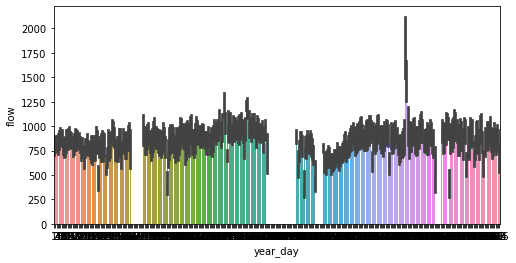

In [ ]:
fig = plt.figure(figsize = (8,4))
sns.barplot(x = preprocessed_df_dates.year_day,  y=preprocessed_df_dates.flow);

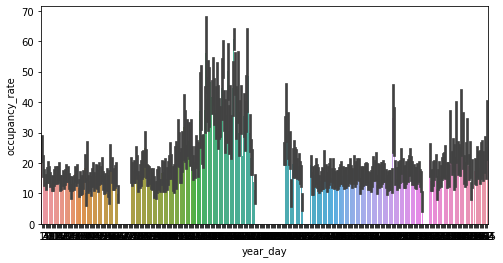

In [ ]:
fig = plt.figure(figsize = (8,4))
sns.barplot(x = preprocessed_df_dates.year_day,  y=preprocessed_df_dates.occupancy_rate);

Thanks to the adding of all the dates, we can see that some periods are missing values...

## Adding holidays

Of course, we cannot consider France without its annual holidays ! We create a dataframe that we will join. 

In [ ]:
holidays = {
    "01/01": "Jour de l'an",
    "01/05": "Fête du Travail",
    "08/05": "Victoire 1945",
    "14/07": "Fête Nationale",
    "15/08": "Assomption",
    "01/11": "Toussaint",
    "11/11": "Armistice 1918",
    "25/12": "Noël"
}

df_holidays = pd.DataFrame.from_dict(holidays, orient='index', columns=['holiday_name'])
df_holidays['month_day'] = df_holidays.index.str[:2].astype(int)
df_holidays['month'] = df_holidays.index.str[3:].astype(int)
df_holidays.reset_index(drop=True, inplace=True)

In [ ]:
df_holidays

,holiday_name,month_day,month
0,Jour de l'an,1,1
1,Fête du Travail,1,5
2,Victoire 1945,8,5
3,Fête Nationale,14,7
4,Assomption,15,8
5,Toussaint,1,11
6,Armistice 1918,11,11
7,Noël,25,12


In [ ]:
# Perform the merge, adding a binary column "is_holiday"
df_with_holidays = preprocessed_df_dates.merge(df_holidays, on=['month', 'month_day'], how='left')
df_with_holidays['is_holiday'] = df_with_holidays['holiday_name'].notna().astype(int)
df_with_holidays.drop(['holiday_name', 'month_day'], axis=1, inplace=True)

In [ ]:
df_with_holidays.head()

,date_clean,flow,occupancy_rate,hour,year_day,week_day,week,month,is_holiday
0,2022-01-01 00:00:00+00:00,NaN,NaN,0,1,5,52,1,1
1,2022-01-01 01:00:00+00:00,NaN,NaN,1,1,5,52,1,1
2,2022-01-01 02:00:00+00:00,NaN,NaN,2,1,5,52,1,1
3,2022-01-01 03:00:00+00:00,500.0,67.08111,3,1,5,52,1,1
4,2022-01-01 04:00:00+00:00,750.0,18.90667,4,1,5,52,1,1


## Adding weather 

From the website https://public.opendatasoft.com/ , I could get access to the meteo in Ile De France. 

In this dataset, only the following columns are interesting : 
1. Date
2. Atmospherical pressure (Pression station)
3. Speed of wind 
4. Temperature (#TeamCelsiusAndNotFahrenheit)
5. Humidity
6. Rain

In [ ]:
meteo_df = data_meteo[["Date", "Pression station","Vitesse du vent moyen 10 mn", "Température (°C)", "Humidité", 'Précipitations dans la dernière heure']]
meteo_df = meteo_df.rename( columns = {"Date" : "date", 
                              "Pression station" : 'atm_pressure',
                             "Vitesse du vent moyen 10 mn" : "wind_speed",
                             "Température (°C)" : "temp", 
                             "Humidité" : 'humidity', 
                             "Précipitations dans la dernière heure" : "rain"})
meteo_df.sort_values("date").head()

,date,atm_pressure,wind_speed,temp,humidity,rain
529,2022-01-01T01:00:00+01:00,101550.0,1.8,9.7,99,0.0
3125,2022-01-01T04:00:00+01:00,101520.0,1.5,8.9,100,0.0
792,2022-01-01T07:00:00+01:00,101480.0,1.0,7.8,100,0.0
1381,2022-01-01T10:00:00+01:00,101470.0,0.6,7.5,100,0.0
793,2022-01-01T13:00:00+01:00,101370.0,3.6,12.2,81,0.0


Let's represent the kde plot of every meteorological feature. 

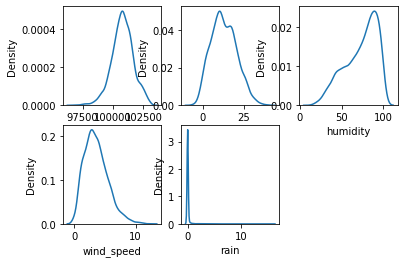

In [ ]:
fig = plt.figure()
fig.add_subplot(231)
sns.kdeplot(meteo_df.atm_pressure)   #top left
fig.add_subplot(232) 
sns.kdeplot(meteo_df.temp)  #top right
fig.add_subplot(233)   #bottom left
sns.kdeplot(meteo_df.humidity)
fig.add_subplot(234)   #bottom right 
sns.kdeplot(meteo_df.wind_speed);
fig.add_subplot(235)  
sns.kdeplot(meteo_df.rain);

Moreover, we can use our function to preprocess the dates. 

In [ ]:
meteo_df= df_date_preprocessing(meteo_df).drop(columns = ["hour","month_day",'year_day',"week_day","week", "month"]).sort_values('date_clean')

In [ ]:
meteo_df.head()

,atm_pressure,wind_speed,temp,humidity,rain,date_clean
529,101550.0,1.8,9.7,99,0.0,2022-01-01 00:00:00+00:00
3125,101520.0,1.5,8.9,100,0.0,2022-01-01 03:00:00+00:00
792,101480.0,1.0,7.8,100,0.0,2022-01-01 06:00:00+00:00
1381,101470.0,0.6,7.5,100,0.0,2022-01-01 09:00:00+00:00
793,101370.0,3.6,12.2,81,0.0,2022-01-01 12:00:00+00:00


We join the meteo data to our original df. 

In [ ]:
df_with_meteo = df_with_holidays.merge(meteo_df, on = "date_clean", how = "left")
df_with_meteo.head()

,date_clean,flow,occupancy_rate,hour,year_day,week_day,week,month,is_holiday,atm_pressure,wind_speed,temp,humidity,rain
0,2022-01-01 00:00:00+00:00,NaN,NaN,0,1,5,52,1,1,101550.0,1.8,9.7,99.0,0.0
1,2022-01-01 01:00:00+00:00,NaN,NaN,1,1,5,52,1,1,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 02:00:00+00:00,NaN,NaN,2,1,5,52,1,1,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 03:00:00+00:00,500.0,67.08111,3,1,5,52,1,1,101520.0,1.5,8.9,100.0,0.0
4,2022-01-01 04:00:00+00:00,750.0,18.90667,4,1,5,52,1,1,NaN,NaN,NaN,NaN,NaN


Nonetheless, we need to fill the missing values. The meteo data is extracted every 3 hours, so we can only **back fill**. 

In [ ]:
df_with_meteo[['temp', 'wind_speed', 'humidity', "atm_pressure", 'rain']] = df_with_meteo[['temp', 'wind_speed', 'humidity', "atm_pressure", 'rain']].fillna(method = "bfill")

# EDA

Let's do the EDA with naming our original dataframe "df" for more clarity. 

In [ ]:
df = df_with_meteo.copy()

## Form Analysis

### Targets

According to the website :

- the **occupancy rate**, which is the time vehicles are present on the loop as a percentage of a fixed time interval (one hour for the data provided). For example, a 25% occupancy rate over an hour means that vehicles were present on the loop for 15 minutes. The rate provides information on traffic congestion. The implementation of the loops is designed to be able to deduce, from a point measurement, the traffic condition on an arc.

- **The flow rate** is the number of vehicles having passed the counting point during a fixed time interval (one hour for the data provided).

Our 2 targets are numerical ones. 

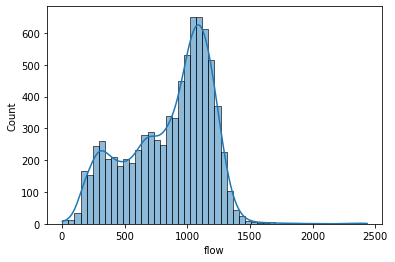

In [ ]:
sns.histplot(df.flow, kde = "True");

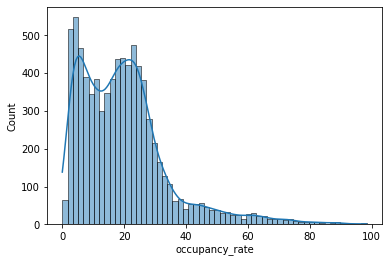

In [ ]:
sns.histplot(df.occupancy_rate, kde = "True");

The occupancy rate hits maximums around 5% and 25%.

### Type of features

In [ ]:
df.dtypes

date_clean        datetime64[ns, UTC]
flow                          float64
occupancy_rate                float64
hour                            int64
year_day                        int64
week_day                        int64
week                           UInt32
month                           int64
is_holiday                      int64
atm_pressure                  float64
wind_speed                    float64
temp                          float64
humidity                      float64
rain                          float64
dtype: object

### Check of missing values

Let's see if we have any missing values. 

In [ ]:
(df.isna().sum()/df.shape[0]*100).sort_values(ascending = False)

occupancy_rate    15.188271
flow              14.945681
date_clean         0.000000
hour               0.000000
year_day           0.000000
week_day           0.000000
week               0.000000
month              0.000000
is_holiday         0.000000
atm_pressure       0.000000
wind_speed         0.000000
temp               0.000000
humidity           0.000000
rain               0.000000
dtype: float64

Let's locate them in the dataset.

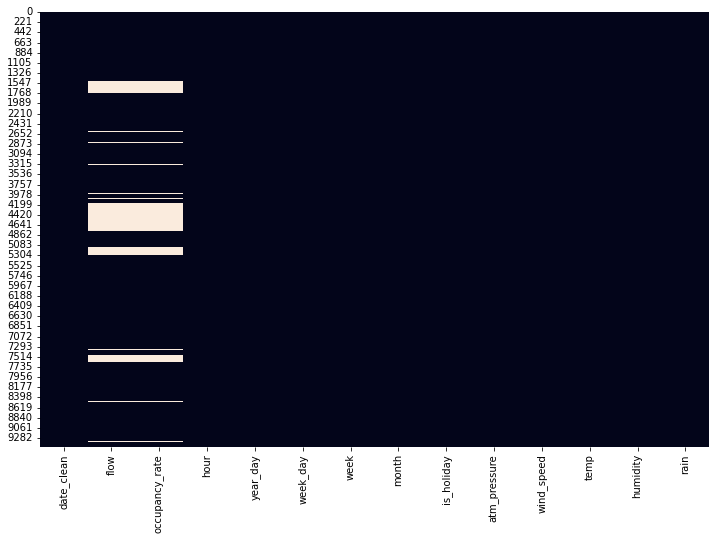

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isna(), cbar=False);

All missing values are related to the targets. 

### Duplicates

In [ ]:
print(f'Number of duplicated records = {df.duplicated().sum()}')

Number of duplicated records = 0


## Content Analysis

### Categorical features

In [ ]:
for col in df.select_dtypes(['object',"int64","UInt32"]) :
  if col=="year_day": # Case of an unreadable pie
    pass
  else : 
    fig = px.pie(df[col].value_counts(), values=df[col].value_counts().values,names =df[col].value_counts().index, title=f'{col}')
    fig.show()

Nothing particular to state, we have an expected distribution for all features. 

### Histogram of continuous variables

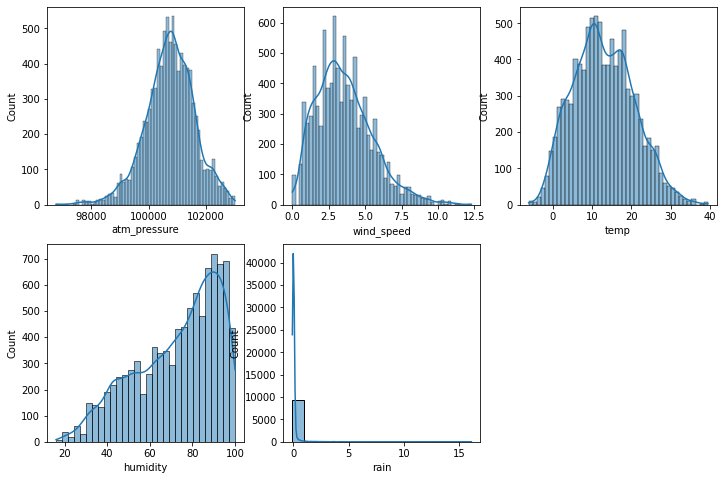

In [ ]:
fig = plt.figure(figsize = (12, 8))
fig.add_subplot(231)
sns.histplot(df.atm_pressure, kde = 'True')   #top left
fig.add_subplot(232) 
sns.histplot(df.wind_speed, kde = 'True')  
fig.add_subplot(233)   #bottom left
sns.histplot(df.temp, kde = 'True')  
fig.add_subplot(234)   #bottom right 
sns.histplot(df.humidity, kde = 'True') ;
fig.add_subplot(235)   
sns.histplot(df.rain, kde = 'True') ;

All those features follow kind of normal law. We can nonetheless see that rain doesn't seem as useful as expected. 

## Confronting features and targets

Now, let's see if any of our features are correlated to the targets. 

### Categorical features

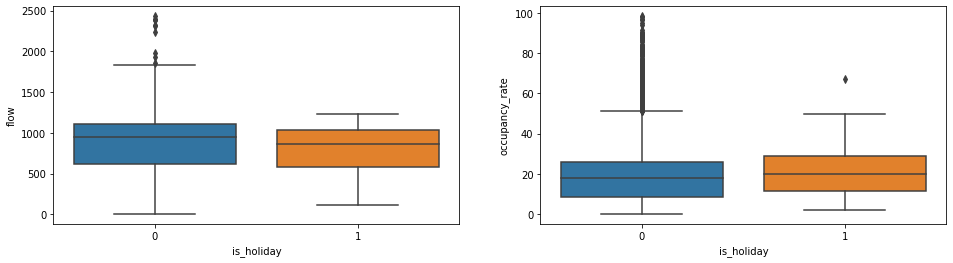

In [ ]:
for col in ["is_holiday"]: 
  fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,4))
  sns.boxplot(x=col, y='flow', data=df, ax = ax1)
  sns.boxplot(y="occupancy_rate", x=col, data=df, ax = ax2);

We can clearly see that holidays have effects on our targets. 

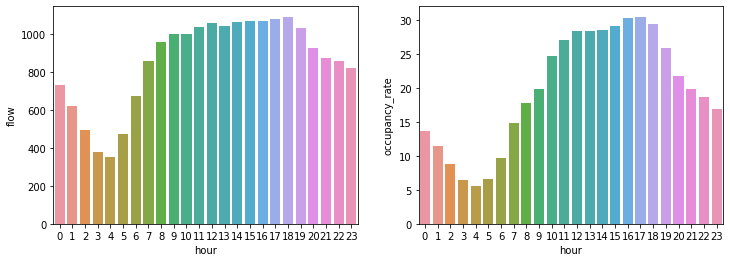

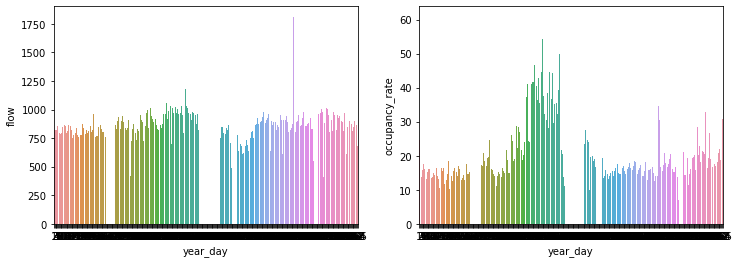

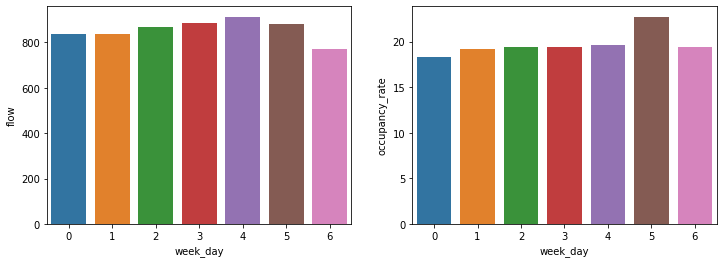

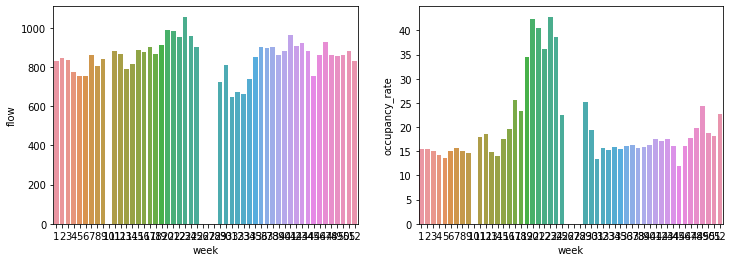

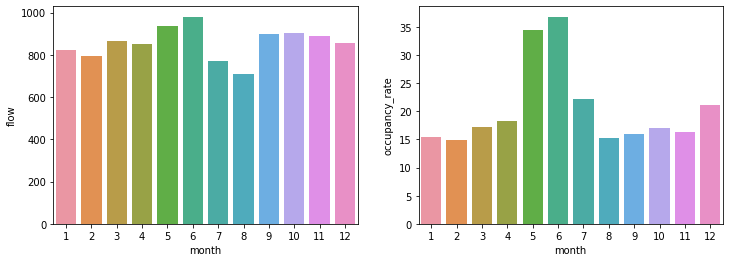

In [ ]:
for col in ["hour", "year_day", "week_day", "week", "month"] : 
  fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,4))
  sns.barplot(x = df.flow.groupby(df[col]).mean().index,  y=df.flow.groupby(df[col]).mean(), ax = ax1);
  sns.barplot(x = df.occupancy_rate.groupby(df[col]).mean().index,  y=df.occupancy_rate.groupby(df[col]).mean(), ax = ax2);

There is **seasonality** in every period of time (more affluence during the weekend, the summer etc...)

### Numerical feature

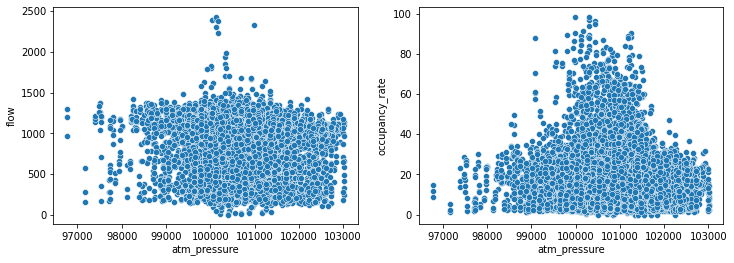

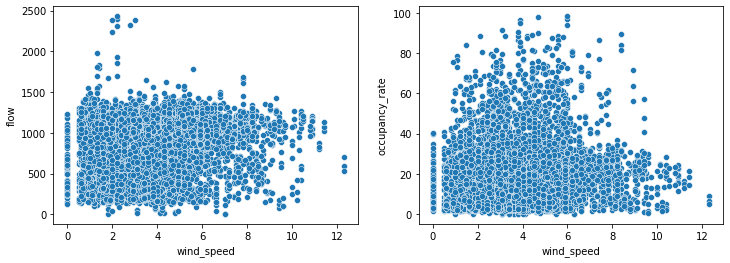

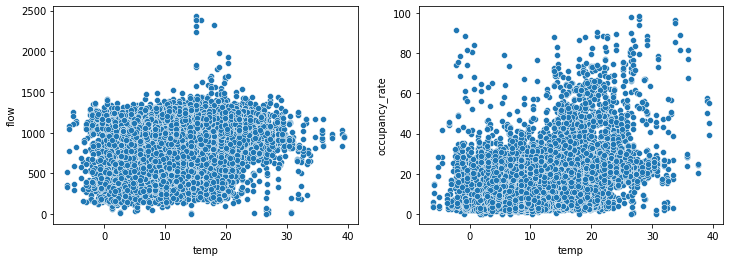

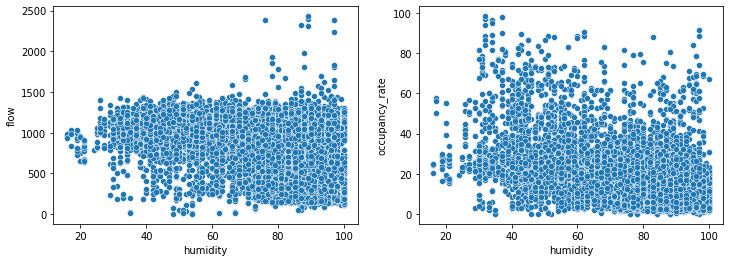

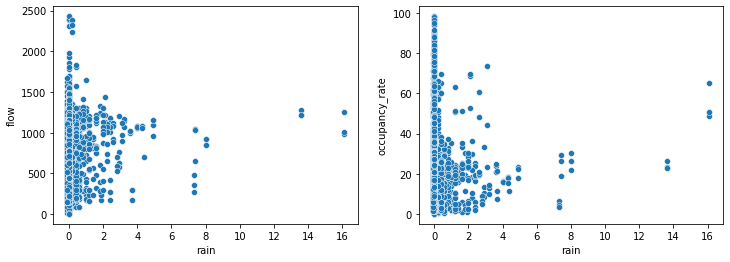

In [ ]:
for col in ['atm_pressure', 'wind_speed', 'temp', 'humidity', 'rain'] : 
  fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,4))
  sns.scatterplot(y = df.flow,  x=df[col], ax = ax1);
  sns.scatterplot(y = df.occupancy_rate,  x=df[col], ax = ax2);

We can detect some correlation between our targets and the features. 

# Preprocessing

Our aim is to build a preprocessing function that can pre process any new data, just giving the date. 

## Handling missing values

For the missing values : 
1. For flow and occupancy rate, we will fillna with the **mean value of the day of week of the same month.**


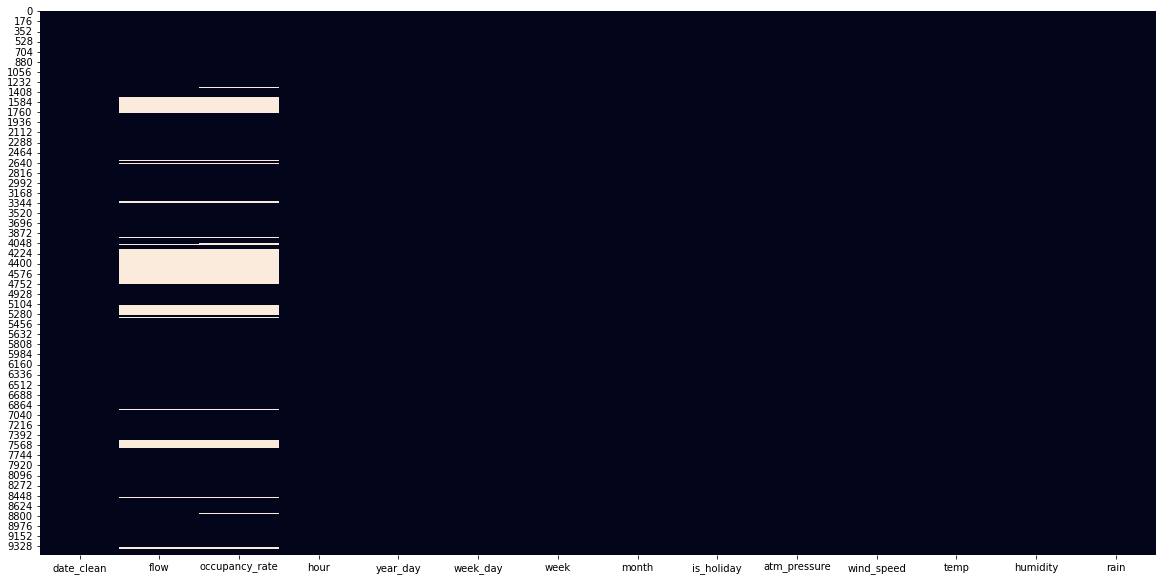

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False);

In [ ]:
#We group by information by month and day of the weel
grouped = df.groupby(['month', 'week_day'])

#We compute the mean for each combination
mean_flow = grouped['flow'].mean()
mean_occ = grouped['occupancy_rate'].mean()

# We reset the index such that the structure fits
mean_flow = mean_flow.reset_index()
mean_occ = mean_occ.reset_index()

#We merge both dataframes
df_before_fill = df.merge(mean_flow, on=['month', 'week_day'], how='left').merge(mean_occ, on=['month', 'week_day'], how='left')

In [ ]:
#We fill the values with each mean
df_before_fill['flow_x'] = df_before_fill['flow_x'].fillna(df_before_fill['flow_y'])
df_before_fill['occupancy_rate_x'] = df_before_fill['occupancy_rate_x'].fillna(df_before_fill['occupancy_rate_y'])

# We delete the column
df_before_fill.drop(['flow_y', 'occupancy_rate_y'], axis=1, inplace=True)

# We rename the column to keep the right one
df  = df_before_fill.rename(columns={'flow_x': 'flow', 
                                     'occupancy_rate_x': 'occupancy_rate'})

df = df.drop(columns = "month")

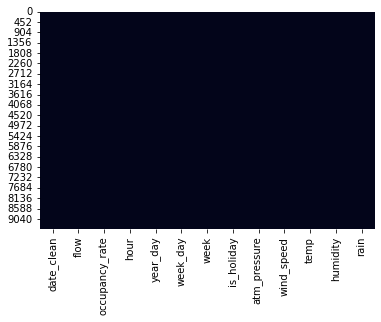

In [ ]:
plt.figure()
sns.heatmap(df.isna(), cbar=False);

## Feature engineering

### Adding Lags

Our objective is to create a function that add 2 columns : our targets with the values of the previous week.

In [ ]:
targets_for_lag = df.copy()[['date_clean', "flow", "occupancy_rate"]].rename(columns = {"date_clean" : "index", 'flow' : "flow_prev_week",'occupancy_rate' : "occupancy_rate_prev_week"})
targets_for_lag['date_clean'] = pd.to_datetime(targets_for_lag["index"])
targets_for_lag = targets_for_lag.set_index('index').drop(columns = "date_clean")
targets_for_lag['date_clean'] = targets_for_lag.index.shift(freq='7D') #dates of the following week with this column for the join 
targets_for_lag.head()

,flow_prev_week,occupancy_rate_prev_week,date_clean
index,,,
2022-01-01 00:00:00+00:00,843.14554,18.071003,2022-01-08 00:00:00+00:00
2022-01-01 01:00:00+00:00,843.14554,18.071003,2022-01-08 01:00:00+00:00
2022-01-01 02:00:00+00:00,843.14554,18.071003,2022-01-08 02:00:00+00:00
2022-01-01 03:00:00+00:00,500.00000,67.081110,2022-01-08 03:00:00+00:00
2022-01-01 04:00:00+00:00,750.00000,18.906670,2022-01-08 04:00:00+00:00


In [ ]:
def shifting(data):
  #Function that adds lag from the previous week.
  df = data.copy()

  df_lag = targets_for_lag.copy()
  
  df = df.merge(targets_for_lag, how = "left", on = "date_clean")

  return df

In [ ]:
shifted_df = shifting(df)
shifted_df.head()

,date_clean,flow,occupancy_rate,hour,year_day,week_day,week,is_holiday,atm_pressure,wind_speed,temp,humidity,rain,flow_prev_week,occupancy_rate_prev_week
0,2022-01-01 00:00:00+00:00,843.14554,18.071003,0,1,5,52,1,101550.0,1.8,9.7,99.0,0.0,NaN,NaN
1,2022-01-01 01:00:00+00:00,843.14554,18.071003,1,1,5,52,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN
2,2022-01-01 02:00:00+00:00,843.14554,18.071003,2,1,5,52,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN
3,2022-01-01 03:00:00+00:00,500.00000,67.081110,3,1,5,52,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN
4,2022-01-01 04:00:00+00:00,750.00000,18.906670,4,1,5,52,1,101480.0,1.0,7.8,100.0,0.0,NaN,NaN


Let's check if the values have been well shifted.

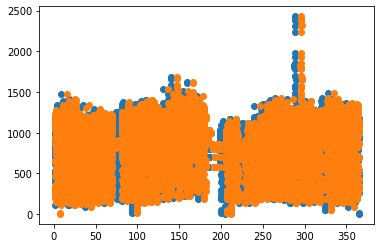

In [ ]:
plt.scatter(shifted_df.year_day , shifted_df.flow)
plt.scatter(shifted_df.year_day , shifted_df.flow_prev_week);

### Week day into categorical, adding weekend 

Here, we just convert some numerical values into categorical ones. 

In [ ]:
def week_day_engineering(df): 
  data = df.copy()
  data["week_day_cat"]=data["week_day"]
  data["week_day_cat"]=data["week_day_cat"].map({0: "Mon", 
                                                           1: 'Tue', 
                                                           2: 'Wed', 
                                                           3: 'Thu',
                                                           4: 'Fri', 
                                                           5: 'Sat', 
                                                           6: 'Sun'})
  
  data["is_week_end"]=data["week_day"]
  data["is_week_end"]=data["is_week_end"].map({0: 0, 
                                                         1: 0, 
                                                         2: 0, 
                                                         3: 0,
                                                         4: 0, 
                                                         5: 1, 
                                                         6: 1})
  
  return data

In [ ]:
shifted_df["week_day_cat"]=shifted_df["week_day"]
shifted_df["week_day_cat"]=shifted_df["week_day_cat"].map({0: "Mon", 
                                                           1: 'Tue', 
                                                           2: 'Wed', 
                                                           3: 'Thu',
                                                           4: 'Fri', 
                                                           5: 'Sat', 
                                                           6: 'Sun'})

In [ ]:
shifted_df["is_week_end"]=shifted_df["week_day"]
shifted_df["is_week_end"]=shifted_df["is_week_end"].map({0: 0, 
                                                         1: 0, 
                                                         2: 0, 
                                                         3: 0,
                                                         4: 0, 
                                                         5: 1, 
                                                         6: 1})

### Taking sinus and cosinus for cycling dates

Here , we have cycle in our dates : a 1st January is after a 31th December, so it might be interesting to keep this closeness in the calendar.
To do so, will add columns that returns cosinus and sinus of cycling dates.

In [ ]:
def feature_engineering(data):
  df = data.copy()

  df = shifting(df)
  df = week_day_engineering(df)

  col_to_change = ["hour", "year_day", "week_day", "week"]

  for col in col_to_change :

    new_col_sin_name = col + "_sin"
    new_col_cos_name = col + "_cos"

    if col == 'hour': 
      dividing_constant = 24
    elif col == 'year_day': 
       dividing_constant = 365
    elif col == 'week_day': 
       dividing_constant = 7
    elif col == 'week': 
       dividing_constant = 52



    df[new_col_sin_name] = np.sin(2 * np.pi * df[col]/dividing_constant)
    df[new_col_cos_name] = np.cos(2 * np.pi * df[col]/dividing_constant)

    df[new_col_sin_name] = df[new_col_sin_name].astype("float")
    df[new_col_cos_name] = df[new_col_cos_name].astype("float")

  df = df.drop(columns =col_to_change)

  return df

In [ ]:
fe_df = feature_engineering(df)
fe_df.head()

,date_clean,flow,occupancy_rate,is_holiday,atm_pressure,wind_speed,temp,humidity,rain,flow_prev_week,occupancy_rate_prev_week,week_day_cat,is_week_end,hour_sin,hour_cos,year_day_sin,year_day_cos,week_day_sin,week_day_cos,week_sin,week_cos
0,2022-01-01 00:00:00+00:00,843.14554,18.071003,1,101550.0,1.8,9.7,99.0,0.0,NaN,NaN,Sat,1,0.000000,1.000000,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0
1,2022-01-01 01:00:00+00:00,843.14554,18.071003,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN,Sat,1,0.258819,0.965926,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0
2,2022-01-01 02:00:00+00:00,843.14554,18.071003,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN,Sat,1,0.500000,0.866025,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0
3,2022-01-01 03:00:00+00:00,500.00000,67.081110,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN,Sat,1,0.707107,0.707107,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0
4,2022-01-01 04:00:00+00:00,750.00000,18.906670,1,101480.0,1.0,7.8,100.0,0.0,NaN,NaN,Sat,1,0.866025,0.500000,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0


Let's plot the values (I find the following graph super satisfying !)

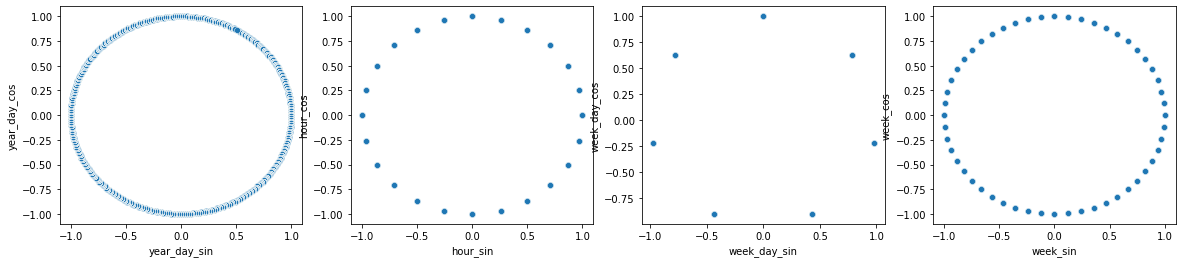

In [ ]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(20,4))

sns.scatterplot(data = fe_df, x = "year_day_sin", y = "year_day_cos", ax = ax1);
sns.scatterplot(data = fe_df, x = "hour_sin", y = "hour_cos", ax = ax2);
sns.scatterplot(data = fe_df, x = "week_day_sin", y = "week_day_cos", ax = ax3);
sns.scatterplot(data = fe_df, x = "week_sin", y = "week_cos", ax = ax4);

## Encoding

Here, only need to apply get dummies. 

In [ ]:
def encoding(df):
    data = df.copy()
    data = pd.get_dummies(data)

    return data

In [ ]:
encoded_df = encoding(fe_df)
encoded_df.head()

,date_clean,flow,occupancy_rate,is_holiday,atm_pressure,wind_speed,temp,humidity,rain,flow_prev_week,occupancy_rate_prev_week,is_week_end,hour_sin,hour_cos,year_day_sin,year_day_cos,week_day_sin,week_day_cos,week_sin,week_cos,week_day_cat_Fri,week_day_cat_Mon,week_day_cat_Sat,week_day_cat_Sun,week_day_cat_Thu,week_day_cat_Tue,week_day_cat_Wed
0,2022-01-01 00:00:00+00:00,843.14554,18.071003,1,101550.0,1.8,9.7,99.0,0.0,NaN,NaN,1,0.000000,1.000000,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0,0,0,1,0,0,0,0
1,2022-01-01 01:00:00+00:00,843.14554,18.071003,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN,1,0.258819,0.965926,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0,0,0,1,0,0,0,0
2,2022-01-01 02:00:00+00:00,843.14554,18.071003,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN,1,0.500000,0.866025,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0,0,0,1,0,0,0,0
3,2022-01-01 03:00:00+00:00,500.00000,67.081110,1,101520.0,1.5,8.9,100.0,0.0,NaN,NaN,1,0.707107,0.707107,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0,0,0,1,0,0,0,0
4,2022-01-01 04:00:00+00:00,750.00000,18.906670,1,101480.0,1.0,7.8,100.0,0.0,NaN,NaN,1,0.866025,0.500000,0.017213,0.999852,-0.974928,-0.222521,6.432491e-16,1.0,0,0,1,0,0,0,0


## Filling or dropping missing values

The only missing values left are the ones created by the **shifting of one week**. We only dropna as it's not a huge loss of information.

In [ ]:
df_no_na = df.dropna().reset_index().drop(columns = ['index'])
df_no_na.head()

,date_clean,flow,occupancy_rate,hour,year_day,week_day,week,is_holiday,atm_pressure,wind_speed,temp,humidity,rain
0,2022-01-01 00:00:00+00:00,843.14554,18.071003,0,1,5,52,1,101550.0,1.8,9.7,99.0,0.0
1,2022-01-01 01:00:00+00:00,843.14554,18.071003,1,1,5,52,1,101520.0,1.5,8.9,100.0,0.0
2,2022-01-01 02:00:00+00:00,843.14554,18.071003,2,1,5,52,1,101520.0,1.5,8.9,100.0,0.0
3,2022-01-01 03:00:00+00:00,500.00000,67.081110,3,1,5,52,1,101520.0,1.5,8.9,100.0,0.0
4,2022-01-01 04:00:00+00:00,750.00000,18.906670,4,1,5,52,1,101480.0,1.0,7.8,100.0,0.0


## Splitting

Here, we are dealing with TimeSeries prediction. Thus, we don't want to shuffle our training and test sets. 

1. We split our data, 
2. then, we will apply on X_train and X_test the preprocessing function. 
3. Then, we can scale our data, fitting only on X_train to avoid data leakage. 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_no_na.drop(columns=['flow', "occupancy_rate"]) 
y = df_no_na[['flow','occupancy_rate']]

X_train_not_processed, X_test_not_processed, both_y_train, both_y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
X_train_not_processed.head()

,date_clean,hour,year_day,week_day,week,is_holiday,atm_pressure,wind_speed,temp,humidity,rain
0,2022-01-01 00:00:00+00:00,0,1,5,52,1,101550.0,1.8,9.7,99.0,0.0
1,2022-01-01 01:00:00+00:00,1,1,5,52,1,101520.0,1.5,8.9,100.0,0.0
2,2022-01-01 02:00:00+00:00,2,1,5,52,1,101520.0,1.5,8.9,100.0,0.0
3,2022-01-01 03:00:00+00:00,3,1,5,52,1,101520.0,1.5,8.9,100.0,0.0
4,2022-01-01 04:00:00+00:00,4,1,5,52,1,101480.0,1.0,7.8,100.0,0.0


## Preprocessing function 

In the preprocessing function, we will follow this order : (we have to keep in mind that the input is X_train or X_test that doesn't have the target in it)
1. Adding the lag (function in the feature_engineering function) , 
2. apply feature engineering with cos/sin functions, 
3. Encode our categorical features, 
4. Scale our numerical features. 

In [ ]:
def preprocessing(df): 
  data = df.copy()

  data = feature_engineering(data)
  data = encoding(data)

  return data

In [ ]:
X_train_processed = preprocessing(X_train_not_processed)
X_test_processed = preprocessing(X_test_not_processed)
X_train_processed.tail()

,date_clean,is_holiday,atm_pressure,wind_speed,temp,humidity,rain,flow_prev_week,occupancy_rate_prev_week,is_week_end,hour_sin,hour_cos,year_day_sin,year_day_cos,week_day_sin,week_day_cos,week_sin,week_cos,week_day_cat_Fri,week_day_cat_Mon,week_day_cat_Sat,week_day_cat_Sun,week_day_cat_Thu,week_day_cat_Tue,week_day_cat_Wed
7579,2022-11-12 19:00:00+00:00,0,101540.0,0.6,9.9,97.0,0.0,1151.0,24.09500,1,-0.965926,0.258819,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7580,2022-11-12 20:00:00+00:00,0,101540.0,0.6,9.9,97.0,0.0,1141.0,20.34611,1,-0.866025,0.500000,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7581,2022-11-12 21:00:00+00:00,0,101540.0,0.6,9.9,97.0,0.0,1178.0,23.04833,1,-0.707107,0.707107,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7582,2022-11-12 22:00:00+00:00,0,101440.0,0.8,8.1,100.0,0.0,1138.0,27.37722,1,-0.500000,0.866025,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7583,2022-11-12 23:00:00+00:00,0,101440.0,0.8,8.1,100.0,0.0,1172.0,23.61611,1,-0.258819,0.965926,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0


## Scaling 

Even if tree based model are not sensible to scaling, I do so to compare it with Linear Regression model. 

For scaling, I use a StandardScaler for the meteorological data, and just divide by 100 for the occupancy rate of the previous week (as it is a rate). 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
col_names = ['atm_pressure', 'wind_speed', 'temp', 'humidity', 'flow_prev_week', 'rain']

ct = ColumnTransformer([
        ('ss', StandardScaler(), col_names)
    ], remainder='passthrough')

In [ ]:
def scaling(df): 
  # function that transform the input df with the fitted parameters on X_train

  data = df.copy()

  X_train_transformed = ct.fit(X_train_processed[col_names])
  data_transformed = ct.transform(data[col_names])

  data[col_names] = data_transformed
  
  data["occupancy_rate_prev_week"]  = data["occupancy_rate_prev_week"]/100

  return data

In [ ]:
X_train_processed.tail()

,date_clean,is_holiday,atm_pressure,wind_speed,temp,humidity,rain,flow_prev_week,occupancy_rate_prev_week,is_week_end,hour_sin,hour_cos,year_day_sin,year_day_cos,week_day_sin,week_day_cos,week_sin,week_cos,week_day_cat_Fri,week_day_cat_Mon,week_day_cat_Sat,week_day_cat_Sun,week_day_cat_Thu,week_day_cat_Tue,week_day_cat_Wed
7579,2022-11-12 19:00:00+00:00,0,101540.0,0.6,9.9,97.0,0.0,1151.0,24.09500,1,-0.965926,0.258819,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7580,2022-11-12 20:00:00+00:00,0,101540.0,0.6,9.9,97.0,0.0,1141.0,20.34611,1,-0.866025,0.500000,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7581,2022-11-12 21:00:00+00:00,0,101540.0,0.6,9.9,97.0,0.0,1178.0,23.04833,1,-0.707107,0.707107,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7582,2022-11-12 22:00:00+00:00,0,101440.0,0.8,8.1,100.0,0.0,1138.0,27.37722,1,-0.500000,0.866025,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0
7583,2022-11-12 23:00:00+00:00,0,101440.0,0.8,8.1,100.0,0.0,1172.0,23.61611,1,-0.258819,0.965926,-0.746972,0.664855,-0.974928,-0.222521,-0.748511,0.663123,0,0,1,0,0,0,0


In [ ]:
X_train= scaling(X_train_processed).drop(columns = "date_clean").fillna(scaling(X_train_processed).mean())
X_test = scaling(X_test_processed).drop(columns = "date_clean").fillna(scaling(X_test_processed).mean())
X_test.head()

,is_holiday,atm_pressure,wind_speed,temp,humidity,rain,flow_prev_week,occupancy_rate_prev_week,is_week_end,hour_sin,hour_cos,year_day_sin,year_day_cos,week_day_sin,week_day_cos,week_sin,week_cos,week_day_cat_Fri,week_day_cat_Mon,week_day_cat_Sat,week_day_cat_Sun,week_day_cat_Thu,week_day_cat_Tue,week_day_cat_Wed
0,0,0.772464,-1.387827,-0.891007,1.499522,-0.112635,1.006888,0.232917,1,0.000000,1.000000,-0.735417,0.677615,-0.781831,0.62349,-0.748511,0.663123,0,0,0,1,0,0,0
1,0,0.582014,-0.962288,-0.931829,1.499522,0.227355,1.192783,0.252433,1,0.258819,0.965926,-0.735417,0.677615,-0.781831,0.62349,-0.748511,0.663123,0,0,0,1,0,0,0
2,0,0.582014,-0.962288,-0.931829,1.499522,0.227355,0.323058,0.241500,1,0.500000,0.866025,-0.735417,0.677615,-0.781831,0.62349,-0.748511,0.663123,0,0,0,1,0,0,0
3,0,0.582014,-0.962288,-0.931829,1.499522,0.227355,0.479078,0.287778,1,0.707107,0.707107,-0.735417,0.677615,-0.781831,0.62349,-0.748511,0.663123,0,0,0,1,0,0,0
4,0,0.442351,-1.015480,-1.285617,1.499522,-0.112635,-0.520110,0.135283,1,0.866025,0.500000,-0.735417,0.677615,-0.781831,0.62349,-0.748511,0.663123,0,0,0,1,0,0,0


## Evaluation function 

I create an evaluation function that plots, for a model :
1. Prints the score, the MSE, RMSE and mean absolute error, 
2. Print the learning curve where **cv is a TimeSeriesSplit** (not shuffle), 
3. Stores into a df the scores to compare them afterwards. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, TimeSeriesSplit

In [ ]:
df_scores = pd.DataFrame(columns = ["model", "MSE", "RMSE", "MAE", "target"])

In [ ]:
def evaluation(model, y_train,y_test,draw_learning_curve, col_to_add ): 

  global df_scores
  global forecast

  #special cases for baseline models and Facebook's Prophet model
  if model=="mean": 
    y_pred = [y_train.mean() for _ in range(len(X_test))]

  elif model == "flow_previous_week":
    y_pred = shifting(X_test_not_processed)["flow_prev_week"]

  elif model == "occ_previous_week":
     y_pred = shifting(X_test_not_processed)["occupancy_rate_prev_week"]

  elif model == "prophet": 
    y_pred = forecast[["yhat"]]

  #General case 
  else :
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Score: {0:.3f}".format(model.score(X_test, y_test)))

  mse = round(mean_squared_error(y_test, y_pred),3)
  rmse = round( mean_squared_error(y_test, y_pred,squared = False), 3)
  mae = round(mean_absolute_error(y_test, y_pred), 3)

  print("MSE: ", mse ) 
  print("RMSE: " , rmse ) 
  print("MAE: " , mae)

  #Adding into df_score the current scores. 
  current_model_score = pd.DataFrame({"model": [str(model)+"_"+str(y_train.name)], "MSE": [mse], "RMSE": [rmse], "MAE":[mae], "target": col_to_add})
  str_to_replace = "Pipeline(steps=[('selector',\n                 SelectKBest(score_func=<function mutual_info_regression at 0x7efef5047280>)),\n                ('regressor',"
  df_scores= pd.concat([df_scores,current_model_score], axis = 0, ignore_index = True).drop_duplicates()
  df_scores["model"]=df_scores.model.apply(lambda text : str(text[len(str_to_replace):]) if len(text)>100 else text)
  

  # Plot of a learning curve with a TimeSeriesSplit.
  if draw_learning_curve==True:

    ts_cv = TimeSeriesSplit(n_splits=5)


    train_sizes, train_scores, test_scores = learning_curve (model , X_train, y_train, cv = ts_cv, scoring = "neg_mean_squared_error", train_sizes = np.linspace(0.1, 1, 10))
    
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Size of the training set")
    plt.ylabel("Root Mean Squared Error")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")

    plt.show()

In [ ]:
reg = LinearRegression()

Score: 0.600
MSE:  46727.857
RMSE:  216.166
MAE:  155.324


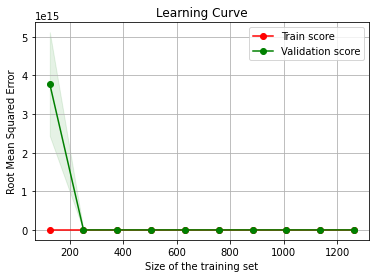

In [ ]:
evaluation(reg, both_y_train.flow, both_y_test.flow, True, "flow")

The graph makes us thing that the error are null, but it's only because the first comuting is 1e15...

## Feature Selection

We can wonder the importance of each features. 

I apply a simple SelectKBest on a grid search with a Xgboost regressor, as we can already guess without a lot of surprise that it will perform very well.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror')
pipe = Pipeline([("selector", SelectKBest(f_regression)),
                 ("regressor",model )])

param_grid = {"selector__k": [i for i in range(1,len(X_train.columns))]}

grid = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), verbose = False, scoring = "neg_mean_squared_error")
grid.fit(X_train, both_y_train.flow)

best_k = grid.best_params_["selector__k"]

In [ ]:
print(f'The ideal number of features to keep is {best_k}.')

The ideal number of features to keep is 4.


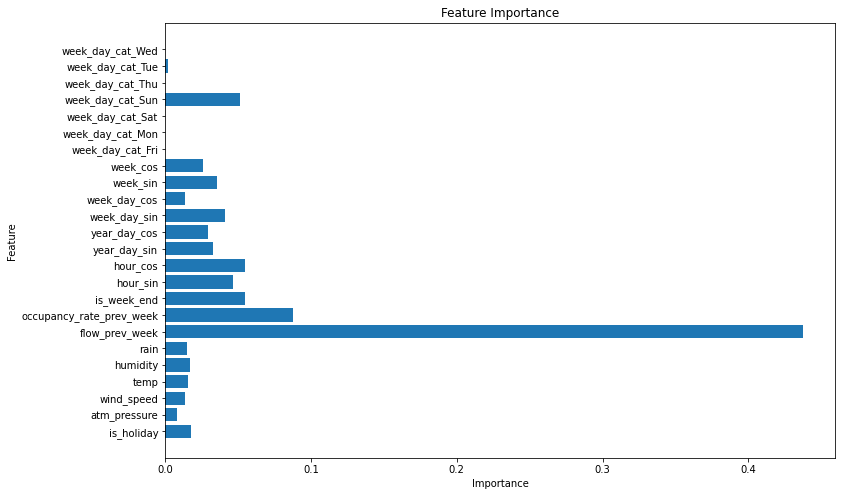

In [ ]:
model.fit(X_train, both_y_train.flow)
importance = model.feature_importances_

plt.figure(figsize=(12,8))
plt.barh(X_train.columns, importance)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

We can directly see that the added information (holidays and weather information) is not as important as the target of the previou week...
But it was worth giving it a try ! 
We can thus analyze that there is a high seasonality from one week to another. 

# Machine Learning Models Benchmark

Let's go to the exciting part ! But before comparing all models, we need a reference. We will take 2 baselines : 
1. predicting the mean of all values, 
2. predicting tkaing the value of the previous week.  

## Baseline model 1 : predicting only with  the mean of the year

Here, we just predict each value with the mean of the year, to know which to which RSME we should compare our models. 

### Flow

In [ ]:
evaluation('mean', both_y_train.flow, both_y_test.flow, False, "baseline_flow")

MSE:  116973.452
RMSE:  342.014
MAE:  295.539


The baseline RSME is thus 342. 

### Occupancy Rate

In [ ]:
evaluation('mean', both_y_train.occupancy_rate, both_y_test.occupancy_rate,False, "baseline_occ_rate")

MSE:  152.192
RMSE:  12.337
MAE:  9.691


Here the RSME is 12. 

## Baseline model 2 : predicting only with the data of the previous week 

### Flow

In [ ]:
evaluation('flow_previous_week', both_y_train.flow, both_y_test.flow,False, "baseline_flow")

MSE:  59510.286
RMSE:  243.947
MAE:  157.511


### Occupancy rate

In [ ]:
evaluation('occ_previous_week', both_y_train.occupancy_rate, both_y_test.occupancy_rate, False, "baseline_occ_rate")

MSE:  120.918
RMSE:  10.996
MAE:  5.962


This second baseline is better. We need to beat : 
1. RMSE of 244 for flow, 
2. RMSE of 11 for occupancy_rate. 

## Classic models

Let's use the brute force :) = evaluation all classic models. 
As computing times are reasonable, I added into the pipeline a selection of the KBest features again. 

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline

In [ ]:
regression_models = {
    'LR': LinearRegression(),
    'RR': Ridge(),
    'LR': Lasso(),
    'ElastR': ElasticNet(),
    'SVR': SVR(),
    'KNR': KNeighborsRegressor(),
    'DTR': DecisionTreeRegressor(),
    'RFR': RandomForestRegressor(),
    'GBR': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

### For target : flow

In [ ]:
y_train = both_y_train.flow
y_test = both_y_test.flow

#### Evaluating all models

LR
Score: 0.551
MSE:  52503.63
RMSE:  229.137
MAE:  167.064


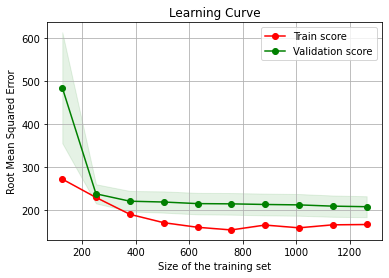

RR
Score: 0.554
MSE:  52110.85
RMSE:  228.278
MAE:  166.468


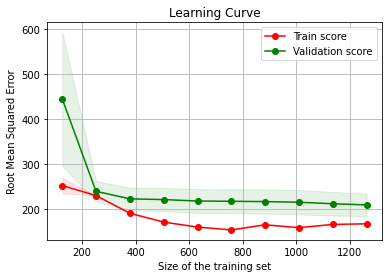

ElastR
Score: 0.480
MSE:  60719.961
RMSE:  246.414
MAE:  202.517


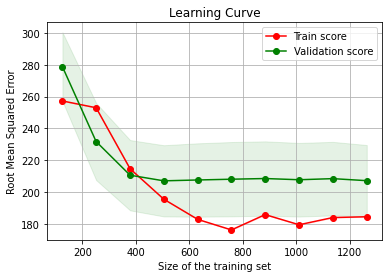

SVR
Score: 0.522
MSE:  55908.602
RMSE:  236.45
MAE:  182.895


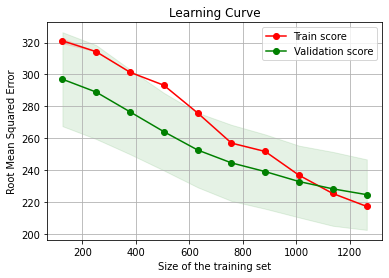

KNR
Score: 0.302
MSE:  81523.984
RMSE:  285.524
MAE:  215.165


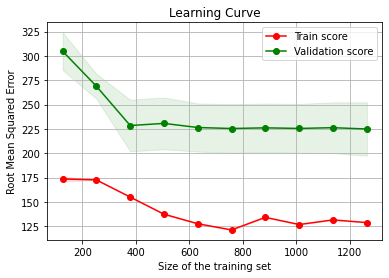

DTR
Score: 0.368
MSE:  73833.448
RMSE:  271.723
MAE:  195.958


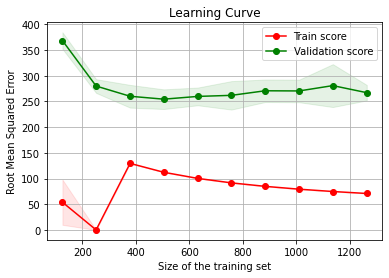

RFR
Score: 0.512
MSE:  57026.171
RMSE:  238.802
MAE:  177.58


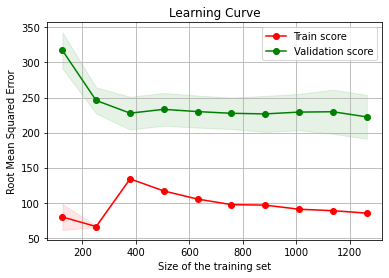

GBR
Score: 0.527
MSE:  55268.714
RMSE:  235.093
MAE:  175.337


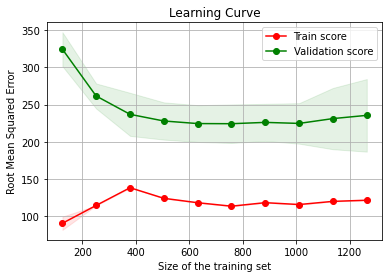

XGBoost
Score: 0.517
MSE:  56493.567
RMSE:  237.684
MAE:  178.456


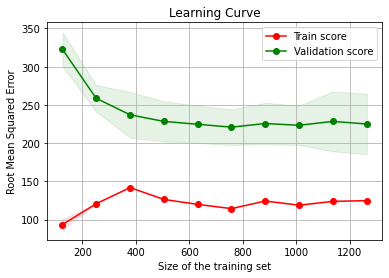

In [ ]:
for name, model in regression_models.items() : 
    print(name)

    pipe = Pipeline([("selector", SelectKBest(mutual_info_regression, k=4)),
                 ("regressor", model)])
    
    evaluation(pipe,y_train, y_test,True, "flow_classic_model")

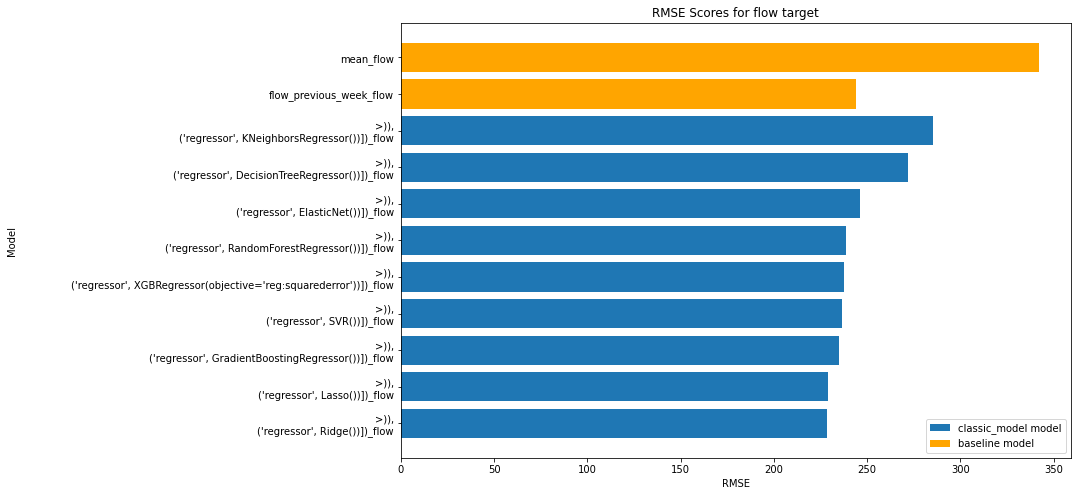

In [ ]:
plt.figure(figsize=(12,8))
plt.barh(df_scores[df_scores.target == 'flow_classic_model'].sort_values("RMSE").model, df_scores[df_scores.target == 'flow_classic_model'].sort_values("RMSE").RMSE,label='classic_model model')
plt.barh(df_scores[df_scores.target == 'baseline_flow'].sort_values("RMSE").model, df_scores[df_scores.target == 'baseline_flow'].sort_values("RMSE").RMSE, label = "baseline model", color = 'orange')
plt.legend()
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.title("RMSE Scores for flow target")
plt.show()

We will thus focus on XGBoost, being aware that the model in not in overfitting. 

#### GridSearchCV with TimeSeriesSplit


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=10   
)

model = XGBRegressor(n_jobs=-1, tree_method='gpu_hist',objective='reg:squarederror')

pipeline = Pipeline([
  ('feature_selection', SelectKBest()),
  ('regression', model)
])

param_grid = {
  'feature_selection__k': [2,3,4,5,10, 15, 20, 21, 22, 23, 24],
  'regression__n_estimators': [30, 40, 50, 60, 70]
}


flow_grid = GridSearchCV(pipeline, param_grid, cv=ts_cv, verbose = False, scoring ="neg_root_mean_squared_error")

flow_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('regression',
                                        XGBRegressor(n_jobs=-1,
                                                     objective='reg:squarederror',
                                                     tree_method='gpu_hist'))]),
             param_grid={'feature_selection__k': [2, 3, 4, 5, 10, 15, 20, 21,
                                                  22, 23, 24],
                         'regression__n_estimators': [30, 40, 50, 60, 70]},
             scoring='neg_root_mean_squared_error', verbose=False)

In [ ]:
print("Best parameters: ", flow_grid.best_params_)
print("Best score: ", flow_grid.best_score_)

Best parameters:  {'feature_selection__k': 22, 'regression__n_estimators': 40}
Best score:  -208.8021837583291


With TimeSeries split, we have for the first split constant values for some columns (the one for which we fillna with the mean). Thus, I remove the warnings. 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Score: 0.645
MSE:  41464.68
RMSE:  203.629
MAE:  151.191


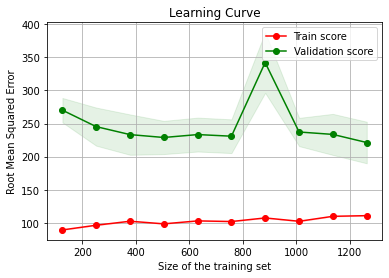

In [ ]:
evaluation(flow_grid.best_estimator_,y_train, y_test,True, "best_xgboost_flow")

### For target : occupancy rate

In [ ]:
y_train = both_y_train.occupancy_rate
y_test = both_y_test.occupancy_rate

#### Evaluating all models

LR
Score: 0.234
MSE:  112.683
RMSE:  10.615
MAE:  6.444


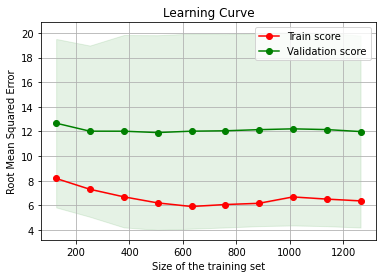

RR
Score: 0.254
MSE:  109.694
RMSE:  10.473
MAE:  6.593


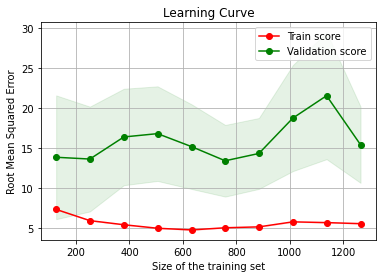

ElastR
Score: 0.257
MSE:  109.174
RMSE:  10.449
MAE:  6.617


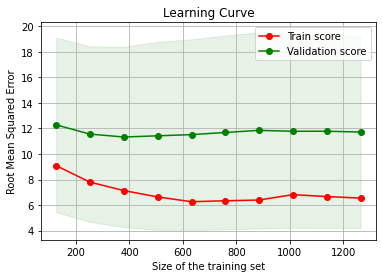

SVR
Score: 0.407
MSE:  87.228
RMSE:  9.34
MAE:  5.517


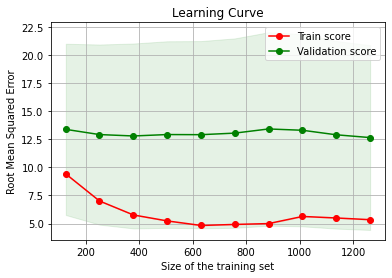

KNR
Score: 0.329
MSE:  98.586
RMSE:  9.929
MAE:  5.966


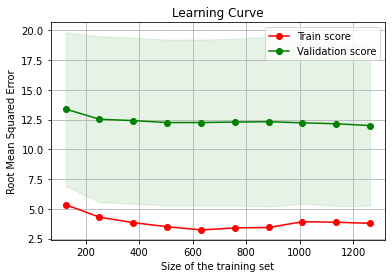

DTR
Score: 0.126
MSE:  128.435
RMSE:  11.333
MAE:  7.247


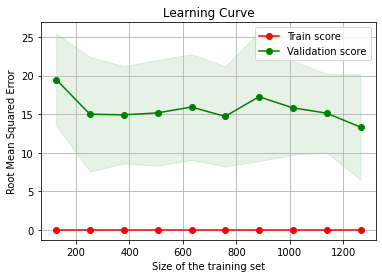

RFR
Score: 0.414
MSE:  86.133
RMSE:  9.281
MAE:  5.408


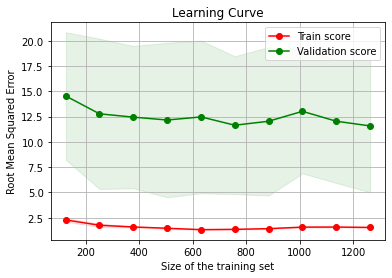

GBR
Score: 0.446
MSE:  81.498
RMSE:  9.028
MAE:  5.292


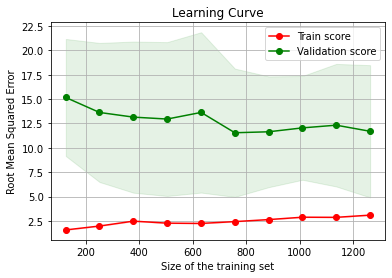

XGBoost
Score: 0.434
MSE:  83.283
RMSE:  9.126
MAE:  5.415


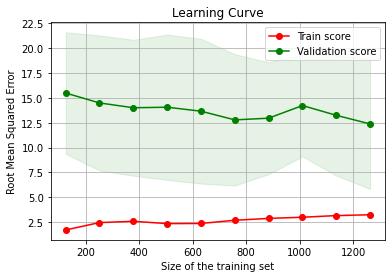

In [ ]:
for name, model in regression_models.items() : 
    print(name)
    evaluation(model,y_train, y_test,True, "occ_rate_classic_model")

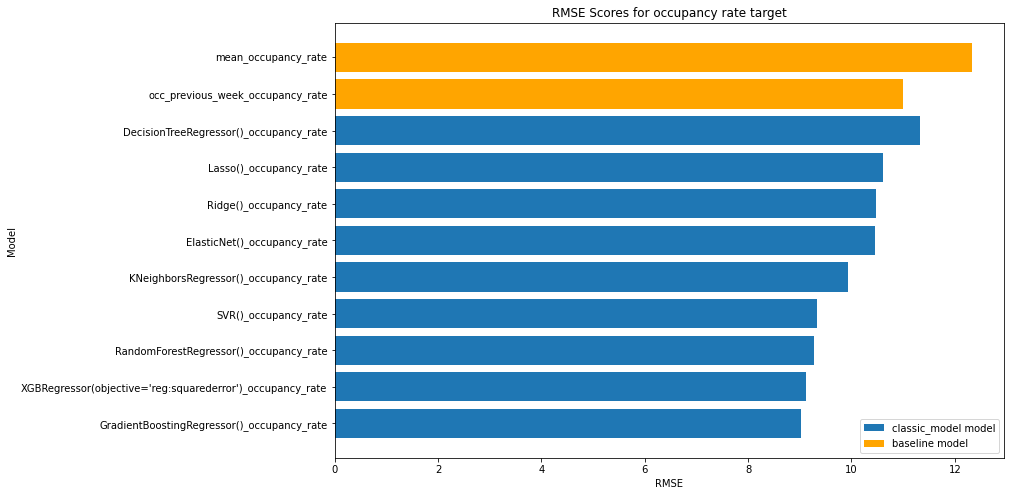

In [ ]:
plt.figure(figsize=(12,8))
plt.barh(df_scores[df_scores.target == 'occ_rate_classic_model'].sort_values("RMSE").model, df_scores[df_scores.target == 'occ_rate_classic_model'].sort_values("RMSE").RMSE,label='classic_model model')
plt.barh(df_scores[df_scores.target == 'baseline_occ_rate'].sort_values("RMSE").model, df_scores[df_scores.target == 'baseline_occ_rate'].sort_values("RMSE").RMSE, label = "baseline model", color = 'orange')
plt.legend()
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.title("RMSE Scores for occupancy rate target")
plt.show()

#### Grid Search 

Here, we have 2 promising models : XGBoost and Gradient Boosting. As I am curitous, let's try both of them !

##### XGBoost Regressor

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=10   
)

model = XGBRegressor(n_jobs=-1, tree_method='gpu_hist',objective='reg:squarederror')

pipeline = Pipeline([
  ('feature_selection', SelectKBest()),
  ('regression', model)
])

param_grid = {
  'feature_selection__k': [2,3,4,5,10, 15, 20, 21, 22, 23, 24],
  'regression__n_estimators': [20, 30, 40]
}

occ_xgb_grid = GridSearchCV(pipeline, param_grid, cv=ts_cv, verbose = False, scoring ="neg_root_mean_squared_error")

occ_xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('regression',
                                        XGBRegressor(n_jobs=-1,
                                                     objective='reg:squarederror',
                                                     tree_method='gpu_hist'))]),
             param_grid={'feature_selection__k': [2, 3, 4, 5, 10, 15, 20, 21,
                                                  22, 23, 24],
                         'regression__n_estimators': [20, 30, 40]},
             scoring='neg_root_mean_squared_error', verbose=False)

In [ ]:
print("Best parameters: ", occ_xgb_grid.best_params_)
print("Best score: ", occ_xgb_grid.best_score_)

Best parameters:  {'feature_selection__k': 24, 'regression__n_estimators': 30}
Best score:  -10.155943034850475


Score: 0.397
MSE:  88.725
RMSE:  9.419
MAE:  5.636


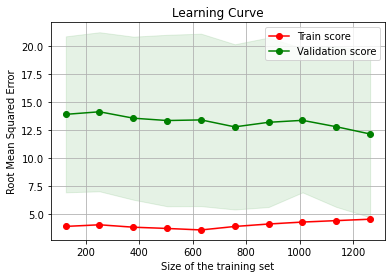

In [ ]:
evaluation(occ_xgb_grid.best_estimator_,y_train, y_test,True, "best_xgboost_occ_rate")

##### Gradient Boosting Regressor

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=10   
)

model = GradientBoostingRegressor()

pipeline = Pipeline([
  ('feature_selection', SelectKBest()),
  ('regression', model)
])

param_grid = {
  'feature_selection__k': [22, 23, 24],
  'regression__n_estimators': [20,30, 40],
   'regression__learning_rate' : [0.01, 0.03, 0.1, 0.3, 1], 
   'regression__max_depth': [3, 5, 7]}

occ_gb_grid = GridSearchCV(pipeline, param_grid, cv=ts_cv, verbose = False, scoring ="neg_root_mean_squared_error")

occ_gb_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('regression',
                                        GradientBoostingRegressor())]),
             param_grid={'feature_selection__k': [22, 23, 24],
                         'regression__learning_rate': [0.01, 0.03, 0.1, 0.3, 1],
                         'regression__max_depth': [3, 5, 7],
                         'regression__n_estimators': [20, 30, 40]},
             scoring='neg_root_mean_squared_error', verbose=False)

In [ ]:
print("Best parameters: ", occ_gb_grid.best_params_)
print("Best score: ", occ_gb_grid.best_score_)

Best parameters:  {'feature_selection__k': 24, 'regression__learning_rate': 0.1, 'regression__max_depth': 3, 'regression__n_estimators': 20}
Best score:  -10.327234067755462


Score: 0.412
MSE:  86.461
RMSE:  9.298
MAE:  5.899


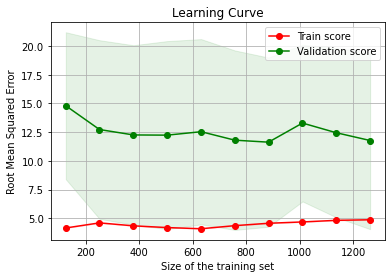

In [ ]:
evaluation(occ_gb_grid.best_estimator_,y_train, y_test,True, "best_grad_boost_occ_rate")

Gradient Boosting Regressor is the great winner ! 

# Facebook's Prophet Model

Here, we use Facebook's Prophet Model that is suited for TimeSeries. We only need to give dates and the associated values, and it forecasts the n-th next values, taking into account seasonality etc...

*The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.*

In [ ]:
import prophet

In [ ]:
df_prophet = df_no_na[["date_clean", "flow"]].rename(columns={"date_clean" : "ds", "flow" : "y"})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], utc=True).dt.tz_convert(None)
df_prophet.head()

,ds,y
0,2022-01-01 00:00:00,843.14554
1,2022-01-01 01:00:00,843.14554
2,2022-01-01 02:00:00,843.14554
3,2022-01-01 03:00:00,500.00000
4,2022-01-01 04:00:00,750.00000


Our dataset is ready to use. Let's split into a training set and a test set to evaluate the predictions. 

In [ ]:
df_train_pph, df_test_pph = train_test_split(df_prophet,test_size= 0.05, random_state = 42, shuffle = False)
df_train_pph.tail()

,ds,y
9001,2023-01-11 01:00:00,402.0
9002,2023-01-11 02:00:00,265.0
9003,2023-01-11 03:00:00,191.0
9004,2023-01-11 04:00:00,193.0
9005,2023-01-11 05:00:00,292.0


As we saw during EDA, there are seasonities for days, weeks and years.

In [ ]:
m = prophet.Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality = True)
m.fit(df_train_pph)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5rb9pip/zvqufior.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5rb9pip/tfc7rlsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18463', 'data', 'file=/tmp/tmpy5rb9pip/zvqufior.json', 'init=/tmp/tmpy5rb9pip/tfc7rlsc.json', 'output', 'file=/tmp/tmpy5rb9pip/prophet_modelxho_olo3/prophet_model-20230228183042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


We construct a "future" dataframe that predicts n values. 

In [ ]:
future = m.make_future_dataframe(periods=len(df_test_pph), freq = "H", include_history = False)
future.tail()

,ds
470,2023-01-30 20:00:00
471,2023-01-30 21:00:00
472,2023-01-30 22:00:00
473,2023-01-30 23:00:00
474,2023-01-31 00:00:00


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
470,2023-01-30 20:00:00,874.023133,607.095826,1159.495361
471,2023-01-30 21:00:00,817.912087,532.004653,1110.348584
472,2023-01-30 22:00:00,787.742098,516.617833,1085.540603
473,2023-01-30 23:00:00,766.433289,495.471970,1047.548432
474,2023-01-31 00:00:00,714.769575,415.195599,996.021990


In [ ]:
evaluation('prophet',df_train_pph.y, df_test_pph.y,False, "prophet_flow")

MSE:  44676.832
RMSE:  211.369
MAE:  167.867


The score is higher that our XGBoost... It's was worth giving it a try ! 
On a personal note, it's stupefying how easy it is to implement a forecasting solution in 5 minutes, without tuning it as needed for an ARIMA model for example. 

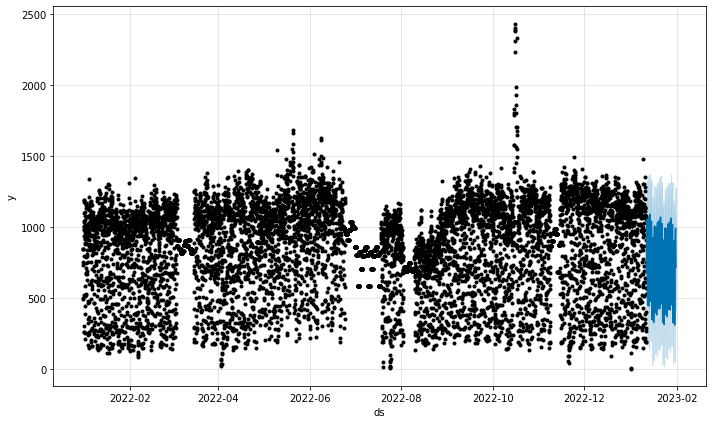

In [ ]:
fig1 = m.plot(forecast)

We can plot the components found by the model. 

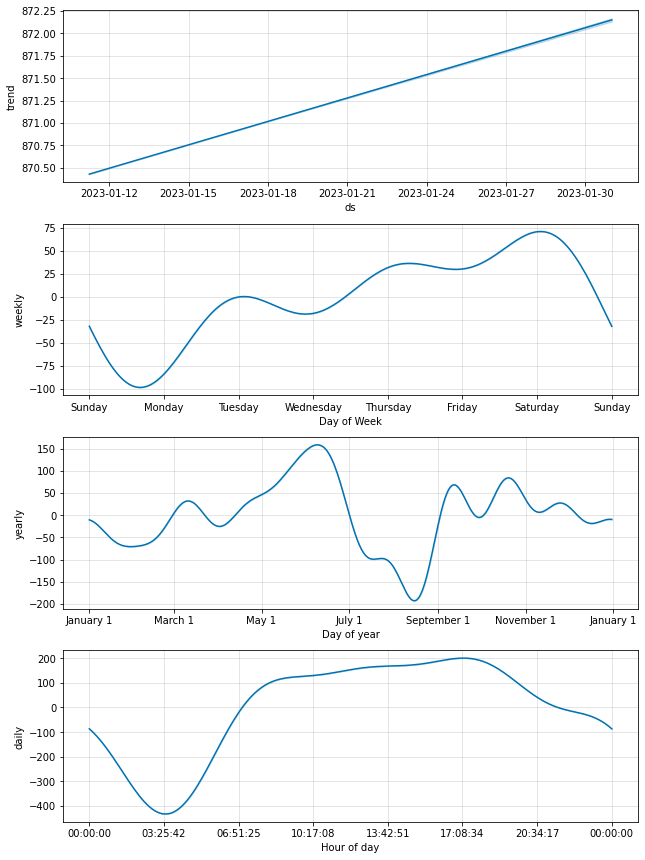

In [ ]:
fig2 = m.plot_components(forecast)

# Forecasting for the next 7 days 

## Processing the right data

We start only from a range of 7-day-long dates, and we need to aim to the same structure as X_test_not_processed

In [ ]:
X_test_not_processed.tail(3)

,date_clean,hour,year_day,week_day,week,is_holiday,atm_pressure,wind_speed,temp,humidity,rain
9478,2023-01-30 22:00:00+00:00,22,30,0,5,0,101900.0,2.2,2.8,90.0,0.0
9479,2023-01-30 23:00:00+00:00,23,30,0,5,0,101900.0,2.2,2.8,90.0,0.0
9480,2023-01-31 00:00:00+00:00,0,31,1,5,0,101900.0,2.2,2.8,90.0,0.0


### 1) Range of dates for the next 7 days

In [ ]:
df_7_days = pd.DataFrame(pd.date_range(start = '31/1/2023', end = '2/6/2023', freq = "H") , columns = ["date_clean"])
df_7_days["date_clean"] = df_7_days["date_clean"].dt.tz_localize('UTC')

In [ ]:
df_7_days_dates_processed = df_date_preprocessing(df_7_days).sort_values("date_clean")

### 2) Adding holidays and weather

In [ ]:
df_7_days_with_holidays = df_7_days_dates_processed.merge(df_holidays, on=['month', 'month_day'], how='left')
df_7_days_with_holidays['is_holiday'] = df_7_days_with_holidays['holiday_name'].notna().astype(int)
df_7_days_with_holidays.drop(['holiday_name', 'month_day'], axis=1, inplace=True)

In [ ]:
df_7_days_with_holidays.tail()

,date_clean,hour,year_day,week_day,week,month,is_holiday
140,2023-02-05 20:00:00+00:00,20,36,6,5,2,0
141,2023-02-05 21:00:00+00:00,21,36,6,5,2,0
142,2023-02-05 22:00:00+00:00,22,36,6,5,2,0
143,2023-02-05 23:00:00+00:00,23,36,6,5,2,0
144,2023-02-06 00:00:00+00:00,0,37,0,6,2,0


In [ ]:
df_7_days_with_meteo = df_7_days_with_holidays.merge(meteo_df, on = "date_clean", how = "left")
df_7_days_with_meteo.tail()

,date_clean,hour,year_day,week_day,week,month,is_holiday,atm_pressure,wind_speed,temp,humidity,rain
140,2023-02-05 20:00:00+00:00,20,36,6,5,2,0,NaN,NaN,NaN,NaN,NaN
141,2023-02-05 21:00:00+00:00,21,36,6,5,2,0,NaN,NaN,NaN,NaN,NaN
142,2023-02-05 22:00:00+00:00,22,36,6,5,2,0,NaN,NaN,NaN,NaN,NaN
143,2023-02-05 23:00:00+00:00,23,36,6,5,2,0,NaN,NaN,NaN,NaN,NaN
144,2023-02-06 00:00:00+00:00,0,37,0,6,2,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_7_days_with_meteo[['temp', 'wind_speed', 'humidity', "atm_pressure", 'rain']] = df_7_days_with_meteo[['temp', 'wind_speed', 'humidity', "atm_pressure", 'rain']].fillna(method = "bfill").fillna(method = "ffill")
df_7_days_with_meteo.tail()

,date_clean,hour,year_day,week_day,week,month,is_holiday,atm_pressure,wind_speed,temp,humidity,rain
140,2023-02-05 20:00:00+00:00,20,36,6,5,2,0,103070.0,5.1,6.7,66.0,0.0
141,2023-02-05 21:00:00+00:00,21,36,6,5,2,0,103070.0,5.1,6.7,66.0,0.0
142,2023-02-05 22:00:00+00:00,22,36,6,5,2,0,103070.0,5.1,6.7,66.0,0.0
143,2023-02-05 23:00:00+00:00,23,36,6,5,2,0,103070.0,5.1,6.7,66.0,0.0
144,2023-02-06 00:00:00+00:00,0,37,0,6,2,0,103070.0,5.1,6.7,66.0,0.0


### 3) Preprocessing the data with the created function

In [ ]:
 df_7_days_processed = preprocessing(df_7_days_with_meteo).drop(columns = "month")
 df_7_days_processed.tail(3)

,date_clean,is_holiday,atm_pressure,wind_speed,temp,humidity,rain,flow_prev_week,occupancy_rate_prev_week,is_week_end,hour_sin,hour_cos,year_day_sin,year_day_cos,week_day_sin,week_day_cos,week_sin,week_cos,week_day_cat_Fri,week_day_cat_Mon,week_day_cat_Sat,week_day_cat_Sun,week_day_cat_Thu,week_day_cat_Tue,week_day_cat_Wed
142,2023-02-05 22:00:00+00:00,0,103070.0,5.1,6.7,66.0,0.0,700.0,11.82556,1,-0.500000,0.866025,0.580800,0.814046,-0.781831,0.62349,0.568065,0.822984,0,0,0,1,0,0,0
143,2023-02-05 23:00:00+00:00,0,103070.0,5.1,6.7,66.0,0.0,608.0,7.70889,1,-0.258819,0.965926,0.580800,0.814046,-0.781831,0.62349,0.568065,0.822984,0,0,0,1,0,0,0
144,2023-02-06 00:00:00+00:00,0,103070.0,5.1,6.7,66.0,0.0,515.0,6.49667,0,0.000000,1.000000,0.594727,0.803928,0.000000,1.00000,0.663123,0.748511,0,1,0,0,0,0,0


### 4) Scaling

In [ ]:
df_7_days_scaled = scaling(df_7_days_processed).drop(columns = "date_clean").fillna(scaling(df_7_days_processed).mean())

Great ! We can predict for the next 7 days. 

## For target : flow

In [ ]:
flow_predictions = flow_grid.best_estimator_.predict(df_7_days_scaled)

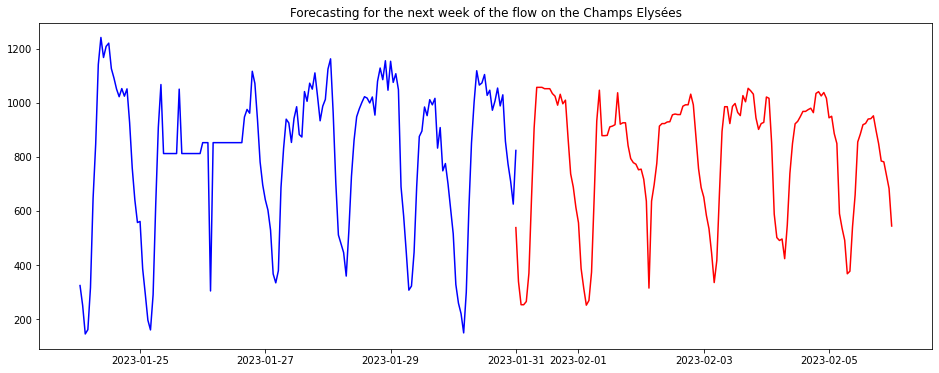

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(X_test_processed.tail(24*7).date_clean,both_y_test.flow.iloc[-24*7:], color = "blue")
plt.plot(df_7_days_processed.date_clean,flow_predictions, color = "red")
plt.title("Forecasting for the next week of the flow on the Champs Elysées");

We can see that it is basically the pattern of the previous week, a little bit squeezed. 

## For target : occupancy_rate

In [ ]:
occ_predictions = occ_gb_grid.best_estimator_.predict(df_7_days_scaled)

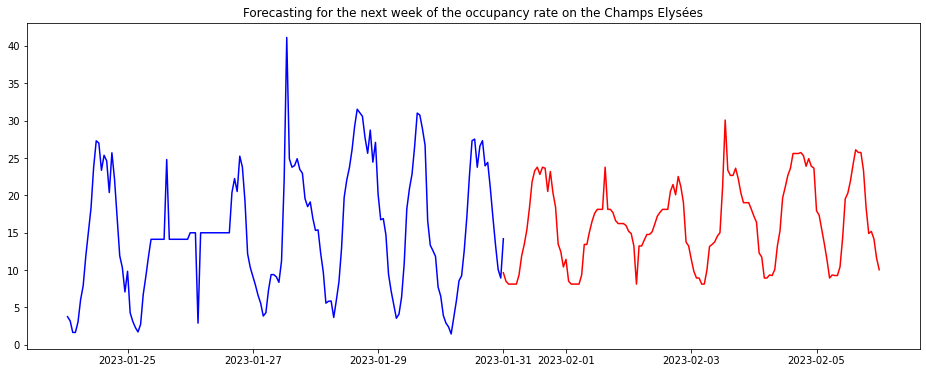

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(X_test_processed.tail(24*7).date_clean,both_y_test.occupancy_rate.iloc[-24*7:], color = "blue")
plt.plot(df_7_days_processed.date_clean,occ_predictions, color = "red")
plt.title("Forecasting for the next week of the occupancy rate on the Champs Elysées");

Same remark : the same pattern as the previous week, but squeezed. 

# Conclusion and opinion

With this project, we saw = 

1.   How to handle weather data, 
2.   Specific preprocessing (cycling feature engineering, adding lag) with dates values,
3. Facebook's prophet model,
4. A pipeline selecting the best features and parameters,
5. Specific cases how to handle missing values. 

Text(0.5, 0, 'RMSE')

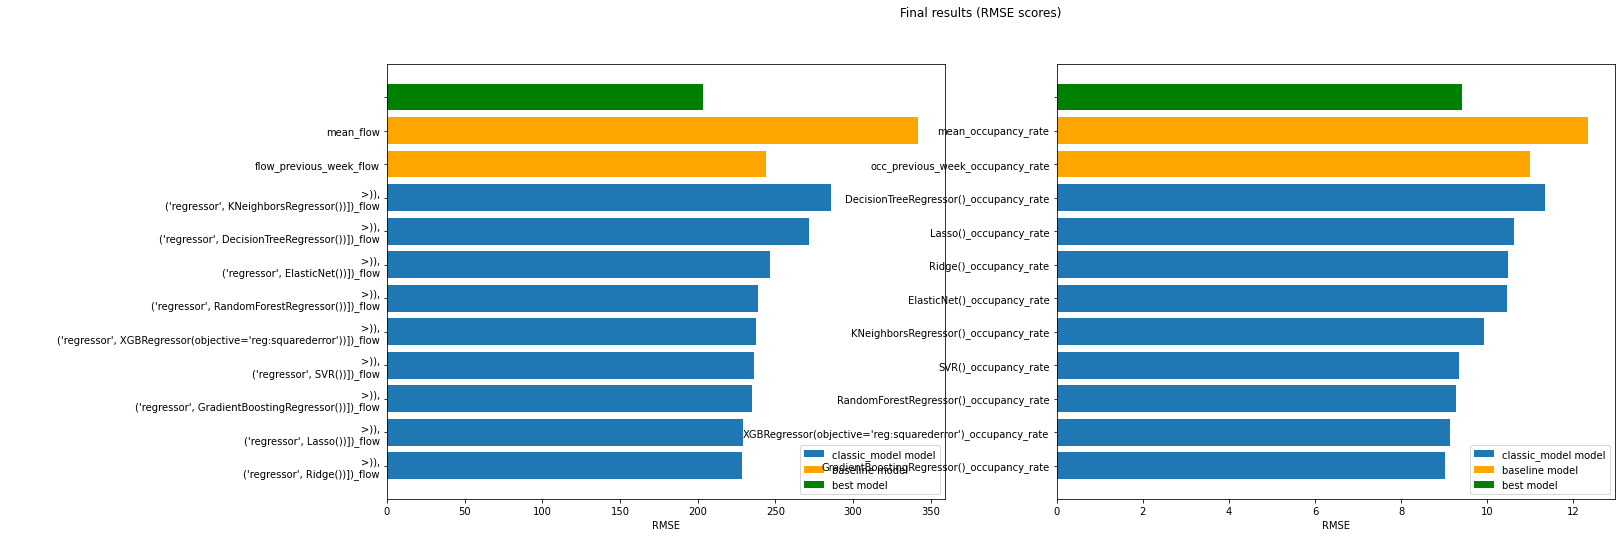

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (22,8))
fig.suptitle('Final results (RMSE scores)')

ax1.barh(df_scores[df_scores.target == 'flow_classic_model'].sort_values("RMSE").model, df_scores[df_scores.target == 'flow_classic_model'].sort_values("RMSE").RMSE,label='classic_model model')
ax1.barh(df_scores[df_scores.target == 'baseline_flow'].sort_values("RMSE").model, df_scores[df_scores.target == 'baseline_flow'].sort_values("RMSE").RMSE, label = "baseline model", color = 'orange')
ax1.barh(df_scores[df_scores.target == 'best_xgboost_flow'].sort_values("RMSE").model, df_scores[df_scores.target == 'best_xgboost_flow'].sort_values("RMSE").RMSE, label = "best model", color = 'green')

ax2.barh(df_scores[df_scores.target == 'occ_rate_classic_model'].sort_values("RMSE").model, df_scores[df_scores.target == 'occ_rate_classic_model'].sort_values("RMSE").RMSE,label='classic_model model')
ax2.barh(df_scores[df_scores.target == 'baseline_occ_rate'].sort_values("RMSE").model, df_scores[df_scores.target == 'baseline_occ_rate'].sort_values("RMSE").RMSE, label = "baseline model", color = 'orange')
ax2.barh(df_scores[df_scores.target == 'best_xgboost_occ_rate'].sort_values("RMSE").model, df_scores[df_scores.target == 'best_xgboost_occ_rate'].sort_values("RMSE").RMSE, label = "best model", color = 'green')

ax1.legend()
ax2.legend()
ax1.set_xlabel("RMSE")
ax2.set_xlabel("RMSE")

Personally, I really enjoyed this project because I had to focus on many details, while always keeping in mind the big picture. 
I am really satisfied that all the preprocessing and feature engineering was not a waste of time (22/24 features kept) and that the best model was not just keeping the lag of the previous week. 

I also discovered for the first time Facebook's Prophet model, that is super easy to implement. Any company with little knowledge in Python can have a timeseries forecasting in 5 minutes ! 

# Last step : go to the Champ Elysées tomorrow and count all the people !

🤓